In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear') #, align_corners=True
        self.conv3_t = nn.Conv2d(64, 64, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 1
        self.conv0_t = nn.Conv2d(16, 1, 3, 1, 1) # Final Decoder
        
    def forward(self, x):
        out = self.bn16(F.relu(self.conv1(x)))
        out = self.bn32(F.relu(self.conv2(out)))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.upsample(self.bn64(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn32(F.relu(self.conv2_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv1_t(out))))
        out = torch.tanh(self.conv0_t(out))
        return out

In [3]:
def get_run_accuracy(noisy_img, clean_img, file, lr, MAX_EPOCHS):
    net = EncDec()
    criterion, optimizer = nn.MSELoss(), optim.Adam(net.parameters(), lr=0.001)
    eta = torch.randn(*noisy_img.size())
    training_error, testing_error, runtime_stats = np.zeros((MAX_EPOCHS)), np.zeros((MAX_EPOCHS)), {}
    
    noise_img = net(noisy_img)[0, 0, :, :].transpose(0,1).detach().numpy()
    
    for itr in range(MAX_EPOCHS):
        out = net(eta)
        optimizer.zero_grad()
        loss = criterion(out, clean_img)
        loss.backward()
        optimizer.step()
        op_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        
        
        training_error[itr] = ((op_img - noise_img)**2).sum()
        testing_error[itr] = ((im - op_img)**2).sum()
    
    runtime_stats['{}_train'.format(file)], runtime_stats['{}_test'.format(file)] = training_error, testing_error
    runtime_stats['model'] = net
    runtime_stats['eta'] = eta
    return runtime_stats

def cross_validated_best_accuracy(noisy_img, clean_img, file, lr, MAX_EPOCHS, MAX_TRIAL, DESIRED_LOSS=-1):
    best_loss, best_stats = 1e5, -1
    for trial in range(MAX_TRIAL):
        collect_stats = get_run_accuracy(noisy_img, clean_img, file, lr, MAX_EPOCHS)
        print ("Current Loss = {}".format(collect_stats['%s_test' % file][-1]))
        if collect_stats['%s_test' % file][-1] < best_loss:
            best_loss, best_stats = collect_stats['%s_test' % file][-1], collect_stats
            print ("Current Best Loss = {}".format(best_loss))  
            
        # Early stopping at desired value
        if DESIRED_LOSS != -1 and best_loss < DESIRED_LOSS:
            return best_stats
    return best_stats

In [4]:
# Finding best accuracy by cross validation
MAX_TRIAL = 10 # Maximum trial
MAX_EPOCHS = 500
lr = 0.01
files = ['lena', 'saturn']
map = {}
for file in files:
    im = imread('../data/denoising/{}.png'.format(file))
    noise = imread('../data/denoising/{}-noisy.png'.format(file))
    noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
    clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
    
    get_best_model = cross_validated_best_accuracy(noisy_img, clean_img, file, lr, MAX_EPOCHS, MAX_TRIAL, 91) 
    map[file] = get_best_model
    
#     net = get_best_model['model']
#     out_img = net(get_best_model['eta'])[0, 0, :, :].transpose(0,1).detach().numpy()
#     error = ((im - out_img)**2).sum()

#     plt.title("Error = %.4f" % error)
#     plt.imshow(out_img)
#     plt.show()
#     plt.savefig('../data/output/denoise/{}.png'.format(file))

/home/ec2-user/anaconda3/envs/cs682/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Current Loss = 133.14037913748686
Current Best Loss = 133.14037913748686
Current Loss = 163.1655563388755
Current Loss = 100.93967112192027
Current Best Loss = 100.93967112192027
Current Loss = 101.94730914647857
Current Loss = 242.14348492779197
Current Loss = 86.79465599858307
Current Best Loss = 86.79465599858307
Current Loss = 28.380580612839218
Current Best Loss = 28.380580612839218


In [5]:
# # Finding best accuracy by cross validation
# MAX_TRIAL = 10 # Maximum trial
# MAX_EPOCHS = 500
# lr = 0.01
# files = ['lena'] #['lena', 'saturn']

# #for file in files:
# file = 'lena'
# im = imread('../data/denoising/{}.png'.format(file))
# noise = imread('../data/denoising/{}-noisy.png'.format(file))
# noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
# clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)

# get_best_model = cross_validated_best_accuracy(noisy_img, clean_img, file, lr, MAX_EPOCHS, MAX_TRIAL, 500) 
    

In [6]:
# # Finding best accuracy by cross validation
# MAX_TRIAL = 10 # Maximum trial
# MAX_EPOCHS = 500
# lr = 0.01
# files = ['saturn'] #['lena', 'saturn']

# #for file in files:
# file = 'lena'
# im = imread('../data/denoising/{}.png'.format(file))
# noise = imread('../data/denoising/{}-noisy.png'.format(file))
# noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
# clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)

# get_best_model = cross_validated_best_accuracy(noisy_img, clean_img, file, lr, MAX_EPOCHS, MAX_TRIAL, 91)
    
    

In [7]:
# net = get_best_model['model']
# out = net(get_best_model['eta'])
# out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
# error = ((im - out_img)**2).sum()

# plt.title("Error = %.4f" % error)
# plt.imshow(out_img)
# plt.show()
# plt.savefig('../data/output/denoise/{}.png'.format('x1'))

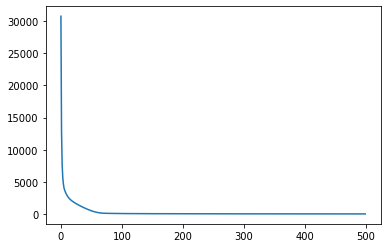

In [8]:
plt.plot(map['saturn']['saturn_test'])

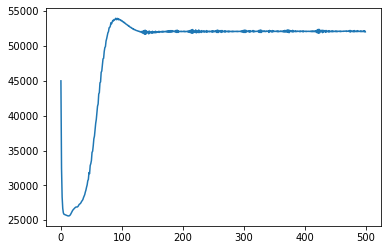

In [9]:
plt.plot(map['lena']['lena_train'])

In [10]:
#map['saturn']['saturn_test']